# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#@title Import Files
import_file = "mlwpy.py" #@param {type:"string"}

#import libraries
import re
import importlib

#create regex
find = re.compile(r"^(.*?)\..*")
# extract file name before .py ending
import_file_no_ext = re.search(find, import_file).group(1)

# copy file to the current notebook
!cp '/content/drive/MyDrive/Colab Notebooks/imports/{import_file}' .
# import module
module = importlib.import_module(import_file_no_ext)

# is there an __all__? if so import all
if '__all__' in module.__dict__:
    names = module.__dict__['__all__']
else:
    # otherwise import all names that don't begin with _
    names = [x for x in module.__dict__ if not x.startswith('_')]

# now bring them in
globals().update({k: getattr(module, k) for k in names})

print(f'Imported file: {import_file_no_ext}.py')

# set matplotlib to display inline
%matplotlib inline

#save default font settings
IPython_default = plt.rcParams.copy()

# set fonts / set text size
#@title matplotlib font settings
small_text = 15 #@param {type:"integer"}
medium_text = 26 #@param {type:"integer"}
large_text = 28 #@param {type:"integer"}
line_marker_size = 5 #@param {type:"slider", min:0, max:10, step:0.5}
legend_shadow = True #@param {type:"boolean"}
fig_width =  8 #@param {type:"number"}
fig_height =  6 #@param {type:"number"}
sns_style = "ticks" #@param ["darkgrid", "whitegrid", "dark", "white", "ticks"]
axis_grid = True #@param {type:"boolean"}
sns_palette = "deep" #@param ["pastel", "muted", "bright", "deep", "colorblind", "dark"]

import matplotlib.pyplot as plt
import seaborn as sns

# restore defaults
plt.rcdefaults()

#run configuration parameters
plt.rcParams['axes.labelsize']   = small_text
plt.rcParams['axes.titlesize']   = small_text
plt.rcParams['xtick.labelsize']  = small_text
plt.rcParams['ytick.labelsize']  = small_text
plt.rcParams['legend.fontsize']  = small_text
plt.rcParams['legend.shadow']    = legend_shadow
plt.rcParams['lines.markersize'] = line_marker_size
plt.rcParams['figure.figsize']   = (fig_width, fig_height)
plt.rcParams['font.size']        = small_text

# seaborn settings
sns.set_style(sns_style, {"axes.grid": axis_grid})
sns.set_palette(sns_palette)

# enable wordwrap
#https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
    td,th,p {
        font-size: 18px
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Imported file: mlwpy.py


# Chapter 3: Predicting Categories: Getting Started with Classification

## 3.1 Classification Tasks

1. *Binary classification* is if there are only two target classes for output. 
2. With more than two target classes, it is a *multiclass* problem. 
3. Some classifiers try to make a decision about an ouput directly.
    1. Similar to limiting the suspects in a crime to people only near where the crime occured.
    2. Other classifiers break the decision into a two-step process.
        1. Build a model of how likely the outcomes are
        2. Pick the most likely outcome.
        3. We want to know that there is a 90% chance someone is sick, compared to a more generic estimate "yes, we think they are sick."
        4. This becomes important when the real-world cost of predictions is high.



# 3.1 The Iris Dataset

1. The *iris* dataset is included with `sklearn`, and it has a long, rich history in machine learning and statistics.   
    1. Sir Ronald Fisher, a mid-20th-century statistician, used the sample data in one of the first academic papers that dealt with what we now call classificaiton.  
    2. Edgar Anderson was responsible for gathering the data, but his name is not as frequently associated with the data.
    3. The final column, the classification target, is the particular species--one of three--of that iris: *setosa, versicolor,* or *virginica*.  
    4. The features are the length and width of the flower's sepals and petals.

<center><img src="https://drive.google.com/uc?id=1dUmuBnN3PHPY2q6Zvt5Hu1dxGEERtJzh&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=200/> <figcaption><i>Fig.1.</i> An iris and its parts</figcaption></center>


### 3.1.2 Load data

In [35]:
#load data
iris = datasets.load_iris()

iris_df = pd.DataFrame(iris.data,
                       columns=iris.feature_names)

iris_df['target'] = iris.target
display(pd.concat([iris_df.head(3),
                  iris_df.tail(3)]))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1000,3.5000,1.4000,0.2000,0
1,4.9000,3.0000,1.4000,0.2000,0
2,4.7000,3.2000,1.3000,0.2000,0
147,6.5000,3.0000,5.2000,2.0000,2
148,6.2000,3.4000,5.4000,2.3000,2
149,5.9000,3.0000,5.1000,1.8000,2


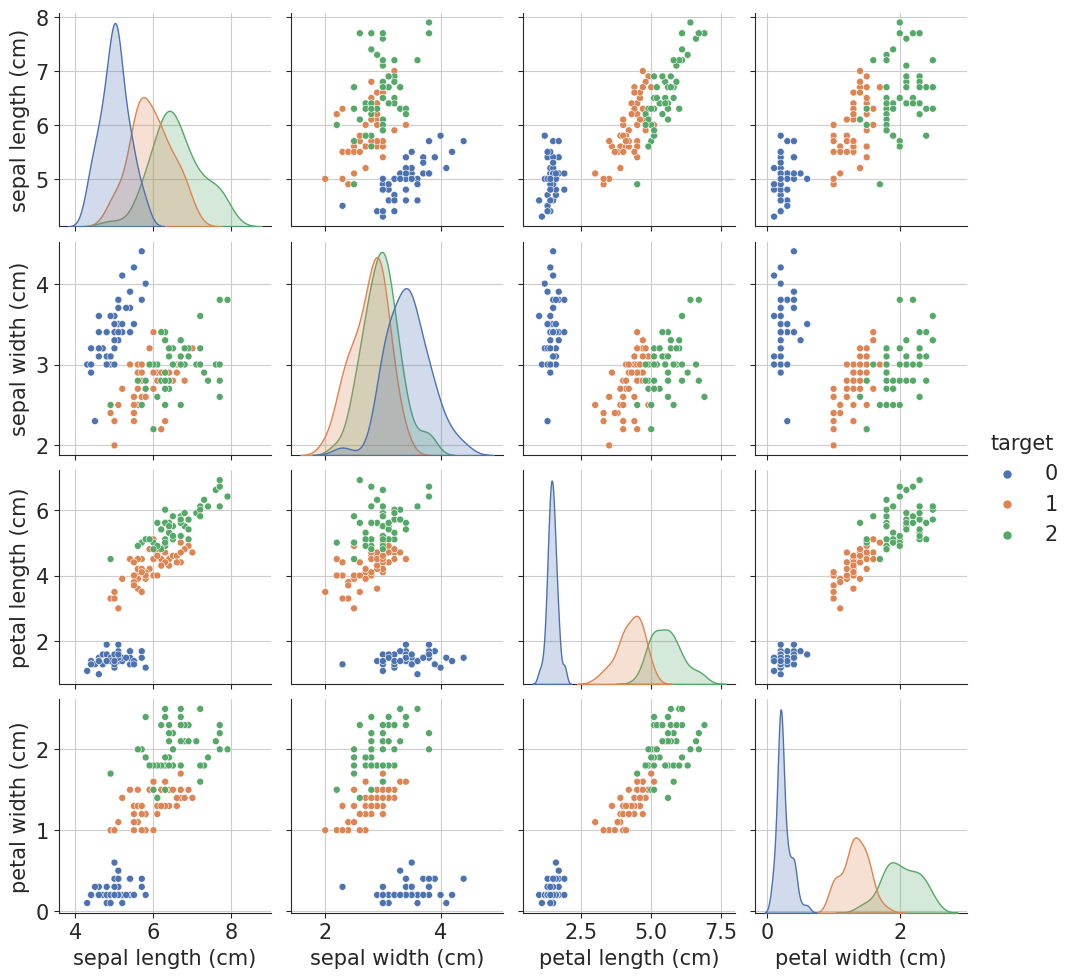

In [36]:
sns.pairplot(iris_df, hue='target', height=2.5, palette="deep")
plt.show()

1. On the diagonal we see histograms of the frequency of the different types of iris differentiated by color.  
2. The off-diagnoal entries are scatter plots of pairs of features. 
3. The diagonals provide mirror images of each other. 
4. In several of the plots, target 0, blue above, stands apart from the other two groups.  Which species is this?

In [37]:
print('targets: {}'.format(iris.target_names),
     iris.target_names[0], sep='\n')

targets: ['setosa' 'versicolor' 'virginica']
setosa


*Setosa* is easy to separate or partition off from the others.  The *vs, versicolor* and *virginica*, are more intertwined.

# 3.3 Training and Testing 🚆🧪

1. In machine learning, we want to do well on *unseen* examples. 
2. Our performance on unseen examples is called *generalization.* 
3. `sklearn` provides a tool, the `train_test_split` function that segments our dataset that lives in the Python variable `iris`. 
4. The dataset has two components already, the *features* and the *target*. 
    1. We split it into a portion that we will use to study and build up our understanding (training)
    2. and a portion that we will use to test ourselves (testing).
5. We started by breaking our dataset into two parts: features and target.
6. Now, we break the features and target into two pieces
    1. Features ▶ training and testing features
    2. Targets ▶ training targets and testing targets

Below is what a basic call to `train_test_split` looks like. 🚆🧪

In [18]:
# simple train-test split
(iris_train_ftrs, iris_test_ftrs,
iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                      iris.target,
                                                      test_size=.25)
print("Train features shape:", iris_train_ftrs.shape)
print("Test features shape:", iris_test_ftrs.shape)

Train features shape: (112, 4)
Test features shape: (38, 4)


1. The training data has 112 examples described by four features.  
2. The testing data has 38 examples described by the same four attributes.  
3. Typically, we sort data into training and testing *randomly*. 🔀
4. Imagine shufflying the examples like a deck of cards and taking the top part for training and the bottom part for testing. 🔀

<center><img src="https://drive.google.com/uc?id=1ccMNmjEWTBVS9RblDdChi-VMfpAOp3lC&authuser=scottminer1205%40gmail.com&usp=drive_fs" width=500/></center>

| iris Python variable | Symbol | Phrase
| :-- | :-- | :-- 
| `iris` | $D_{all}$ | (total) dataset
| `iris.data` | $D_{ftrs}$ | train and test features
| `iris.target` | $D_{tgt}$ | train and test targets
| `iris_train_ftrs` | $D_{train}$ | training features
| `iris_test_ftrs` | $D_{test}$ | testing features
| `iris_train_tgt` | $D_{train_{tgt}}$ | training target
| `iris_test_tgt` | $D_{test_{tgt}}$ | testing target

One slight hiccup in the table is that `iris.data` refers to just the input *features*.  This is the terminology that scikit-learn chose.

# 3.4 Evaluation

1. For now, we will use the *accuracy*.  
2. The formula is $ \frac{\text{#correct answers}}{\text{#questions}} $.  
3. We can write a snippet of code that captures this idea.
4. Taking as an example a student who answers `True` to every multiple choice question. 

In [28]:
answer_key = np.array([True, True, False, True])
student_answers = np.array([True, True, True, True]) # student w/ wrong answers!

1. We can calculate the accuracy by hand in three steps:

    1. Mark each answer right or wrong.
    2. Add up the correct answers.
    3. Calculate the percent.

In [32]:
correct = answer_key == student_answers
correct

array([ True,  True, False,  True])

### 3.4.1 Manual Accuracy

In [30]:
num_correct = correct.sum() # True == 1, add them up
print('manual accuracy:', num_correct / len(answer_key))

manual accuracy: 0.75


Behind the scenes, sklearn's `metrics.accuracy_score` does an equivalent calculation:

In [31]:
print('sklearn accuracy:', metrics.accuracy_score(answer_key,
                                                  student_answers))

sklearn accuracy: 0.75


1. So far we introduced two key evaluation components.
    1. The material we study from and the material we test from.
    2. Choosing a method to score the exam (accuracy).
2. Now, we introduce the first learning method.

# 3.5 Simple Classifier #1: Nearest Neighbors, Long Distance Relationships, and Assumptions

1. K-Nearest Neighbors is one of the simpler ideas to make predictions from labeled datasets.  It consists of the following steps:

    1. Find a way to describe the similarity of two different examples
    2. When making a new, unknown prediction, simply take the value from the most similar known example.

2. We may consider more than *just* the single most similar example.

    1. We may describe similarity between pairs of examples
    2. Pick several of the most-similar examples
    3. Combine the picks to get a single answer

## 3.5.1 Defining Similarity

1. We can define similar by calculating a distance between pairs of examples: `similarity = distance(example_one, example_two)`.  
2. The idea of similarity becomes encoded in the way we calculate the distance. 

1. Let's look at three ways of calculating the similarity of a pair of examples.
    1. *Euclidean* distance, harkens back to high-school geometry or trig.
The formula for *Euclidean* distance is $c^2 = a^2 + b^2$ or $c = \sqrt{a^2 + b^2}$. 

    2. Another option for calculating similarity makese sense when we have examples that consist of simple *Yes, No* or *True, False* features.   
        1. With Boolean data, we can compare two examples by counting up the number of features that are *different*.  
        2. This is known as the *Hamming* distance.  Hamming is very similar to accuracy, which is the percent *correct*.  
        3. In other words, the Hamming distance is the percent of answers the *same* as the target, which is $ \frac{\text{correct}}\text{{total}}$.
        4. Hamming distance refers to the number of *differences*.  `sklearn`'s list of possible distance calculators is in the documentation for `neighbors.DistanceMetric`: there are about twenty metrics defined there.

<center><img src="https://drive.google.com/uc?id=1dUP5DqIbka8W75k-MaOX_neyqeAdzb5D&authuser=scottminer1205%40gmail.com&usp=drive_fs" width="400"><figcaption><i>Fig. 2.</i> Distances from components</figcaption></center>



## 3.5.2 The *k* in *k*-NN

After going to the trouble of choosing how to measure our local neighborhood, we have to decide who gets to vote and how we will combine the votes.  In other words, we have to combine the different opinions in the neighbor.  Therefore, instead of only considering *the* nearest neighbor, we might consider a small number of nearby neighbors.

Expanding the neighborhood gives us more perspectives.  An expanded neighborhood protects against noise in the data.  Common numbers of neighbors are 1, 3, 10, and 20.

When talking about *k-NN* for classification, we can write *k-NN-C*.

## 3.5.3 Answer Combination

The last thing we need to decide is how to combine the values or votes from similar neighbors.  For example, in the case of an animal classificaiton problem, if four of our nearest neighbors identify a test example as *cat, cat, dog* and *zebra*, how do we combine these votes to choose an ultimate prediction?  Typically, we take the most frequent response, *cat* in the above scenario.

We can use this same process on *regression* problems to predict numerical values.  All we change is how to combine our neighbors' votes.  For instance, if three neighbors give numerical values of 3.1, 2.2, and 7.1, how do we combine their votes?  We can use any statistic we want, but the most popular methods are the mean (average) and the median (middle of the ordered data).

## 3.5.4 Parameters and Nonparametric Methods

Unlike many other models, *k*-NN outputs cannot be computed from an input example and the values of a small, fixed set of adjustable knobs.  In other words, we need *all* of the training data to figure out an output value.

Imagine throwing away just a single training example.  If this example is *the* nearest neighbor of a new test example, the missing training example will affect our output.  There are other ML methods with similar requirements.  Still, others require some, but not *all* of the training data when it comes to test time.

The number of knobs on the *k*-NN machine depends on the number of examples in the training data.  We can describe this dependency differently.  The factory machine that represents ML models had a side tray where we can feed additional information.  We can treat training data as additional information.  Whether we (1) grow the number of knows or (2) use the side-input tray, we say that *k*-NN is a nonparametric learning method, which means the relationship between the features and targets cannot be captured solely using a *fixed* number of parameters.

This concept is related to the idea of parametric versus nonparametric statistics.  That is, that nonparametric statistics assume less about a basket of data.  However, we do *not* make any assumptions about the way our black-box factory machine relates to reality.  Parametric models (1) make an assumption about the form of the model and then (2) pick a specific model by setting the parameters.  This corresponds to two questions: what knobs are on the machine, and what values are they set to?

We don't make assumptions like that with *k*-NN. However, *k*-NN *does* make and rely on assumptions.  The most important assumption is that our similarity calculation is related to the *actual* example similarity that we want to capture.


## 3.5.5 Building a *k*-NN Classification Model

*k*-NN is our first example of a *model*.  This is the process for building a *k*-NN model:

1. We want to build a 3-NN model.
2. We want the model to capture the relationship between the iris training features and the iris training target.
3. We want to use the model to *predict*--on previously unseen test examples--the iris target species.
4. We want to evaluate the quality of the predictions using accuracy.

![](https://github.com/sminerport/ml-4-every1/blob/master/knn.jpg?raw=1)

Below, we perform the following tasks:

1. Create a 3-NN model
2. Fit that model on the training data
3. Use the model to predict on the test data
4. Evaluate the predictions using accuracy.

In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
fit = knn.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

# evaluate our predictions against the held-back testing targets
print("3NN accuracy:",
      metrics.accuracy_score(iris_test_tgt, preds))

3NN accuracy: 1.0


# 3.6 Simple Classifier #2: Naive Bayes, Probability, and Broken Promises

In [34]:
nb = naive_bayes.GaussianNB()
fit = nb.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

print("NB accuracy:",
      metrics.accuracy_score(iris_test_tgt, preds))

NB accuracy: 1.0


# 3.7 Simplistic Evaluation of Classifiers

## 3.7.1 Learning Performance



In [ ]:
from sklearn import (datasets, metrics,
                     model_selection as skms,
                    naive_bayes, neighbors)

# we set random_state so the results are reproducible
# otherwise we get different training and testing sets
iris = datasets.load_iris()
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                        iris.target,
                                                        test_size=.90,
                                                        random_state=42)

models = {'kNN': neighbors.KNeighborsClassifier(n_neighbors=3),
          'NB': naive_bayes.GaussianNB()}

for name, model in models.items():
    fit = model.fit(iris_train_ftrs, iris_train_tgt)
    predictions = fit.predict(iris_test_ftrs)
    
    score = metrics.accuracy_score(iris_test_tgt, predictions)
    print("{:>3s} {:0.2f}".format(name, score))

kNN 0.96
 NB 0.81


In a Jupyter notebook, we can use Python's `timeit` module, which uses the Jupyter cell magic `%timeit`.

In [ ]:
# 3.7.2.4 Time

%timeit -r1 datasets.load_iris()


996 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


The `-r1` tells `timeit` to measure the timing of the snippet once.  If we give a higher `r`, for repeats, the code will be run multiple times and we will get statistics.  Recent versions of Jupyter default to calculating the mean and standard deviation of the results.  `%%timeit`--the two-percents make it a *cell magic*, which applies the same strategy to the entire block of code in a cell.

In [ ]:
%%timeit -r1 -n1
(iris_train_ftrs, iris_test_ftrs,
 irits_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                         iris.target,
                                                         test_size=.25)

3.85 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now, let's point our chronometer (`timeit`) at our learning workflow:

In [ ]:
%%timeit -r1

nb    = naive_bayes.GaussianNB()
fit   = nb.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

592 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


In [ ]:
%%timeit -r1

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
fit = knn.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

3.59 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


If we want to time one line in a cell--for example, we only want to see how long it takes to fit the models--we can use a single-precent version called a *line magic*, of `timeit`:

In [ ]:
# fitting
nb = naive_bayes.GaussianNB()
%timeit -r1 fit = nb.fit(iris_train_ftrs, iris_train_tgt)

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
%timeit -r1 fit = knn.fit(iris_train_ftrs, iris_train_tgt)

425 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
258 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


In [ ]:
# predicting
nb  = naive_bayes.GaussianNB()
fit = nb.fit(iris_train_ftrs, iris_train_tgt)
%timeit -r1 preds = fit.predict(iris_test_ftrs)

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
fit = knn.fit(iris_train_ftrs, iris_train_tgt)
%timeit -r1 preds = fit.predict(iris_test_ftrs)

186 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4.69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


There seems to be a bit of a tradeoff. *k*-NN is faster to fit, but slower to predict.  Conversely, NB takes a bit of time to fit, but is faster predicting.  If you're wondering why I didn't use the `knn` and `nb` from the prior cell, it's because when you `%timeit`, variable assignment are trapped inside the `timeit` magic and don't leak back out to our main code.  For example, trying to use `preds` as 'normal code in the prior cell will result in a `NameError`.

# 3.7.2.5 Memory

First we need to install `memory_profile` using `pip install memory_profiler`

Then, in our notebook, we can use `%load_ext` to load the `memory_profiler`: `%load_ext memory_profiler`.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade memory_profiler

You should consider upgrading via the 'c:\users\scott\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
%%memit
nb    = naive_bayes.GaussianNB()
fit   = nb.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs) 

peak memory: 172.68 MiB, increment: 0.00 MiB


And for nearest neighbors:

In [ ]:
%%memit
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
fit = knn.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

peak memory: 172.65 MiB, increment: 0.00 MiB


# 3.7.3 Stand-Alone Resource Evaluation

To minimize the concerns and to reduce confounding variables, it is useufl to write small, stand-alone programs when testing memory use.

```python
import memory_profiler, sys
from mlwpy import *

@memory_profiler.profile(precision=4)

def knn_memtest(train, train_tgt, test):
     knn   = neighbors.KNeighborsClassifier(n_neighbors=3)
     fit   = knn.fit(train, train_tgt)
     preds = fit.predict(test)

if __name__ == "__main__":
     iris = datasets.load_iris()
     tts = skms.train_test_split(iris.data,
                                 iris.target,
                                 test_size=.25)
     (iris_train_ftrs, iris_test_ftrs,
      iris_train_tgt,  iris_test_tgt) = tts
     tup = (iris_train_ftrs, iris_train_tgt, iris_test_ftrs)
     knn_memtest(*tup)
```        


In [ ]:
import memory_profiler, sys
from mlwpy import *

@memory_profiler.profile(precision=4)

def knn_memtest(train, train_tgt, test):
     knn   = neighbors.KNeighborsClassifier(n_neighbors=3)
     fit   = knn.fit(train, train_tgt)
     preds = fit.predict(test)

if __name__ == "__main__":
     iris = datasets.load_iris()
     tts = skms.train_test_split(iris.data,
                                 iris.target,
                                 test_size=.25)
     (iris_train_ftrs, iris_test_ftrs,
      iris_train_tgt,  iris_test_tgt) = tts
     tup = (iris_train_ftrs, iris_train_tgt, iris_test_ftrs)
     knn_memtest(*tup)

ERROR: Could not find file <ipython-input-38-4e254daf25fe>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.


There are a few ways to use `memory_profiler`.  We've seen the line and cell magins in the previous section.  In `knn_memtest.py`, we use the `@memory_profiler.profile` *decorator*.  The extra line of Python tells the memory profiler to track the memory usage of `knn_memtest` on a line-by-line basis.  When we run the script, we see memory-related output for each line of `knn_memtest`.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade seaborn

You should consider upgrading via the 'c:\users\scott\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
!python knn_memtest.py

Filename: C:\Users\Scott\Foundations of Machine Learning\knn_memtest.py

Line #    Mem usage    Increment  Occurences   Line Contents
     4 144.7539 MiB 144.7539 MiB           1   @memory_profiler.profile(precision=4)
     5                                         
     6                                         def knn_memtest(train, train_tgt, test):
     7 144.7656 MiB   0.0117 MiB           1        knn   = neighbors.KNeighborsClassifier(n_neighbors=3)
     8 144.9180 MiB   0.1523 MiB           1        fit   = knn.fit(train, train_tgt)
     9 145.0078 MiB   0.0898 MiB           1        preds = fit.predict(test)




Here's another stand-alone script to measure the memory usage of Naive Bayes:

```python
import functools as ft
import memory_profiler
from mlwpy import *

def nb_go(train_ftrs, test_ftrs, train_tgt):
    nb     = naive_bayes.GaussianNB()
    fit    = nb.fit(train_ftrs, train_tgt)
    preds  = fit.predict(test_ftrs)
    
def split_data(dataset):
    split = skms.train_test_split(dataset.data,
                                  dataset.target,
                                  test_size=.25)
    return split[:-1] # don't need test tgt

def msr_mem(go, args):
    base = memory_profiler.memory_usage()[0]
    mu = memory_profiler.memory_usage((go, args),
                                       max_usage=True)
    print("{:<3}: ~{:.4f} MiB".format(go.__name__, mu-base))
    
if __name__ == "__main__":
    msr = msr_mem
    go = nb_go
    
    sd = split_data(datasets.load_iris())
    msr(go, sd)
```
   

Here's another stand-alone script to measure the memory usage of Naive Bayes:

In [ ]:
!python nb_memtest.py

nb_go: ~0.1367 MiB


`nb_go` has the *model-fit-predict* pattern we saw above.  `split_data` wraps `train_test_split` in a convenient way to use with `nb_go`.  The new piece is setting up the timing wrapper in `msr_mem`.  Essentially, we ask what memory is used now, run `nb_go`, and then see the maximum memory used along the way.  Then we take the max, subtract away what we were using before, `max-baseline`, and that's the peak memory used by `nb_go`.  `nb_go` gets passed in to `msr_mem` as `go` and then finds its way to `memory_usage`.

We can write a similar `msr_time` driver to evaluate time, and we can write a similar `knn_go` to kick off a k-NN classifier for measuring time and memory.  Here are all four pieces in a single script.

In [ ]:
!python perf_01.py mem nb
!python perf_01.py time nb

nb_go: ~0.1367 MiB
nb_go : ~0.0670 sec


And with *k*-NN:

In [ ]:
!python perf_01.py mem knn
!python perf_01.py time knn

knn_go: ~0.3906 MiB
knn_go: ~0.1501 sec


In summary, here are our results:

Method | Accuracy | ~Time(s) | ~Memory (MiB)
 --- | --- | --- | ---
*k*-NN | 0.96 | 0.15 | .40
NB | 0.80 | 0.06 | .14

At this time, it is important not to read too much into the *accuracy scores.*